In [1]:
# from Binaries import *
import matplotlib.pyplot as plt
from Binaries import GLOBAL
import numpy as np

plt.rcParams["figure.figsize"] = [30, 15]

In [2]:
# Implementation of Tobias Schulz baseline algorithm in python
def substract_baseline(trace : np.ndarray) -> np.ndarray :

    def calculate_baseline(*args) -> list :

        baselines = []
        for window in args:

            while True:

                mode, count = None, 0
                
                # calculate mode of the trace windows
                for value in range(int(min(window)), int(max(window))):
                    current_count = window.count(value)
                    if current_count > count:
                        mode, count = value, current_count

                if mode == None: mode = window[0]
                upper, lower = mode + 2* np.std(window), mode - 2* np.std(window)
                to_remove = [bin for bin in window if bin > upper or bin < lower]           
                if to_remove != []: [window.remove(value) for value in to_remove]
                else: break

            baselines.append([np.mean(window), np.std(window)])

        return baselines

    (i, sigma_i), (f, sigma_f) = calculate_baseline(list(trace[:300]), list(trace[-300:]))
    delta_B, sigma_B = f - i, np.sqrt(sigma_i**2 + sigma_f**2)

    if delta_B >= 5 * sigma_B: raise ElectronicsError                               # discard trace
    
    elif 5 * sigma_B > delta_B >= 0:                                                # approx. constant
        
        Baseline, _ =  calculate_baseline(list(trace))[0]
        return trace - Baseline

    elif 0 > delta_B >= -sigma_B or (-sigma_B > delta_B and (max(trace) - i) < 50): # step function

        front, end = trace[:np.argmax(trace)], trace[np.argmax(trace):]
        return np.array(list(front - i) + list(end - f))
    
    elif -sigma_B > delta_B:                                                        # signal undershoot

        interpolated_baseline = [i + delta_B * (bin - 300)/1448 for bin in range(300, 1748)]
        interpolated_baseline += [f for i in range(300)]
        interpolated_baseline = np.array(interpolated_baseline)
        
        q_front = np.sum(trace[:300] - i)                                           # front estimate integral
        tau     = 41e-6 / 8.33e-9                                                   # decay constant ~4922 bins

        for iteration in range(3):

            baseline_substracted = trace[300:] - interpolated_baseline
            cumulative_charges, last_charge = [], q_front

            for k in range(len(baseline_substracted)):

                last_charge *= np.exp(-1/tau)
                last_charge += baseline_substracted[k]
                cumulative_charges.append(last_charge)

            q_ref = cumulative_charges[-150]

            if q_ref < 0: print(q_ref); raise ElectronicsError

            interpolated_baseline = (i + delta_B * np.array(cumulative_charges) / q_ref)

        return np.array( list(trace[:300] - i) + list(trace[300:] - interpolated_baseline))

In [3]:
# container for the combined trace
class Trace():

    def __init__(self, trace_options : list, baseline_data : np.ndarray, signal_data : tuple = None) :

        self.q_peak = trace_options[0]
        self.q_charge = trace_options[1]
        self.length = trace_options[2]
        self.sigma = trace_options[3]
        self.mu = trace_options[4]

        # if trace_options[5] is not None:
        #     self.inject = trace_options[5]
        # else: self.inject = self.poisson()

        self.downsample = trace_options[6]

        # if signal_data is not None: 
        #     super().__init__(signal_data, self.length)
        #     self.has_signal = True
        # else:
        self.Signal = None
        self.has_signal = False

        # if self.inject:
        #     self.injections_start, self.injections_end, self.Injected = InjectedBackground(self.inject, self.length)
        #     self.has_accidentals = True
        # else: 
        self.Injected = None
        self.has_accidentals = False

        self.Baseline = baseline_data

        if self.has_accidentals and self.has_signal:
            self.pmt_1, self.pmt_2, self.pmt_3 = self.convert_to_VEM( self.Baseline, self.Signal, self.Injected, mode = "peak" )
            self.int_1, self.int_2, self.int_3 = self.convert_to_VEM( self.Baseline, self.Signal, self.Injected, mode = "charge" )

        elif self.has_accidentals and not self.has_signal:
            self.pmt_1, self.pmt_2, self.pmt_3 = self.convert_to_VEM( self.Baseline, self.Injected, mode = "peak" )
            self.int_1, self.int_2, self.int_3 = self.convert_to_VEM( self.Baseline, self.Injected, mode = "charge" )
        
        elif self.has_signal and not self.has_accidentals:
            self.pmt_1, self.pmt_2, self.pmt_3 = self.convert_to_VEM( self.Baseline, self.Signal, mode = "peak" )
            self.int_1, self.int_2, self.int_3 = self.convert_to_VEM( self.Baseline, self.Signal, mode = "charge" )
        
        else: 
            self.pmt_1, self.pmt_2, self.pmt_3 = self.convert_to_VEM( self.Baseline, mode = "peak" )
            self.int_1, self.int_2, self.int_3 = self.convert_to_VEM( self.Baseline, mode = "charge" )

        if self.downsample:
            
            if self.has_signal:
                self.signal_start = self.signal_start // 3
                self.signal_end = self.signal_end // 3

            if self.has_accidentals:
                self.injections_start = [start // 3 for start in self.injections_start ]
                self.injections_end = [end // 3 for end in self.injections_end ]

            self.length = GLOBAL.n_bins // 3

    # poissonian for background injection
    def poisson(self) -> int :

        return np.random.poisson( GLOBAL.background_frequency * GLOBAL.single_bin_duration * self.length )

    # extract pmt data plus label for a given trace window 
    def get_trace_window(self, window : tuple, skip_integral : bool = False, skip_metadata : bool = True) -> tuple : 

        start, stop = window

        pmt_1, pmt_2, pmt_3 = self.pmt_1[start : stop], self.pmt_2[start : stop], self.pmt_3[start : stop]
        label = self.calculate_signal_overlap(window)
        metadata = np.array([label, self.Energy, self.SPDistance, self.Zenith]) if not skip_metadata and self.has_signal else [label, None, None, None]
        integral = None if skip_integral else self.integrate(window)

        return np.array([pmt_1, pmt_2, pmt_3]), label, integral, metadata        

    # calculate number of bins of signal in sliding window
    def calculate_signal_overlap(self, window : tuple) -> int :
        
        if self.has_signal: 
            return len(range(max(window[0], self.signal_start), min(window[-1], self.signal_end)))
        else: return 0

    # return the mean of integrated PMT signals (VEM_charge) for a given window
    def integrate(self, window : np.ndarray) -> float : 

        start, stop = window

        return np.mean(np.sum([self.int_1[start : stop], self.int_2[start : stop], self.int_3[start : stop]], axis = 1))

    # convert from ADC counts to VEM 
    def convert_to_VEM(self, *args, mode : str) -> np.ndarray :

        args = list(args)
        ADC_to_VEM = self.q_peak if mode == "peak" else self.q_charge
        simulated = GLOBAL.q_peak if mode == "peak" else GLOBAL.q_charge
        factor = simulated / np.array(ADC_to_VEM)

        # Signal + Injections ALWAYS have simulated q_peak/q_area 
        # Background has simulated q_peak/q_area if NOT random traces
        # otherwise set to values defined in RandomTrace class (l281)
        baseline = args.pop(0)
        signal = np.zeros_like(baseline)

        # Add particles from simulation
        for component in args:
            for i, pmt in enumerate(component):
                signal[i] += pmt

        # Add noise from random traces / background model
        for i, background_pmt in enumerate(baseline):
            signal[i] += background_pmt * factor[i]

        if self.downsample: 
            signal = self.apply_downsampling(signal)

        for i, pmt in enumerate(signal):
            signal[i] = np.floor(pmt) / simulated

        return signal

    @staticmethod
    def apply_downsampling(trace : np.ndarray) -> np.ndarray :

        # ensure downsampling works as intended
        # cuts away (at most) the last two bins
        if trace.shape[-1] % 3 != 0:
            trace = np.array([pmt[0 : -(trace.shape[-1] % 3)] for pmt in trace])

        # see /cr/data01/filip/offline/trunk/Framework/SDetector/UUBDownsampleFilter.h for more information
        kFirCoefficients = [ 5, 0, 12, 22, 0, -61, -96, 0, 256, 551, 681, 551, 256, 0, -96, -61, 0, 22, 12, 0, 5 ]
        buffer_length = int(0.5 * len(kFirCoefficients))
        kFirNormalizationBitShift = 11
        # kADCsaturation = 4095                             # bit shift not really needed

        n_bins_uub      = np.shape(trace)[1]                # original trace length
        n_bins_ub       = int(n_bins_uub / 3)               # downsampled trace length
        sampled_trace   = np.zeros((3, n_bins_ub))          # downsampled trace container

        temp = np.zeros(n_bins_uub + len(kFirCoefficients))

        for i_pmt, pmt in enumerate(trace):

            temp[0 : buffer_length] = pmt[:: -1][-buffer_length - 1 : -1]
            temp[-buffer_length - 1: -1] = pmt[:: -1][0 : buffer_length]
            temp[buffer_length : -buffer_length - 1] = pmt

            # perform downsampling
            for j, coeff in enumerate(kFirCoefficients):
                sampled_trace[i_pmt] += [temp[k + j] * coeff for k in range(0, n_bins_uub, 3)]

        # clipping and bitshifting
        for i, pmt in enumerate(sampled_trace):
            for j, adc in enumerate(pmt):
                sampled_trace[i,j] = np.clip(int(adc) >> kFirNormalizationBitShift, a_min = -20, a_max = None)              # why clip necessary, why huge negative values?
                # sampled_trace[i,j] = int(adc) >> kFirNormalizationBitShift

        return sampled_trace

    # wrapper for pretty printing
    def __repr__(self) -> str :

        reduce_by = 10 if self.downsample else 30
        trace = list(" " * (self.length // reduce_by))

        # indicate background
        if self.has_accidentals:
            for start, stop in zip(self.injections_start, self.injections_end):
                start, stop = start // reduce_by, stop // reduce_by - 1

                trace[start] = "b"

                for signal in range(start + 1, stop):
                    trace[signal] = "-"

                trace[stop] = "b"

        # indicate signal
        if self.has_signal:
            start, stop = self.signal_start // reduce_by, self.signal_end // reduce_by - 1

            trace[start] = "S" if trace[start] == " " else "X"

            for signal in range(start + 1, stop):
                trace[signal] = "=" if trace[signal] == " " else "X"

            trace[stop] = "S" if trace[stop] == " " else "X"

            metadata = f" {self.Energy:.4e} eV @ {self.SPDistance} m from core   "

        else: metadata = " Background trace                "
        
        return "||" + "".join(trace) + "||" + metadata

    # wrapper for plotting a trace
    def __plot__(self, ls, alpha = 1.0) -> None :

        x = range(self.length)

        plt.plot(x, self.pmt_1, c = "green", label = f"PMT #1{', downsampled' if self.downsample else ''}", lw = 1, ls = ls, alpha = alpha)
        plt.plot(x, self.pmt_2, c = "orange", label = f"PMT #2{', downsampled' if self.downsample else ''}", lw = 1, ls = ls, alpha = alpha)
        plt.plot(x, self.pmt_3, c = "steelblue", label = f"PMT #3{', downsampled' if self.downsample else ''}", lw = 1, ls = ls, alpha = alpha)

        if self.has_signal:
            plt.axvline(self.signal_start, ls = "--", c = "red", lw = 2)
            plt.axvline(self.signal_end, ls = "--", c = "red", lw = 2)

        if self.has_accidentals:
            for start, stop in zip(self.injections_start, self.injections_end):
                plt.axvline(start, ls = "--", c = "gray")
                plt.axvline(stop, ls = "--", c = "gray")

        plt.xlim(0, self.length)
        plt.ylabel("Signal strength / VEM")
        plt.xlabel("Bin / 25 ns" if self.downsample else "Bin / 8.3 ns")
        plt.legend()
        # plt.show()

In [4]:
VEM = np.loadtxt("ADST_VEM.csv")
ADC = np.loadtxt("ADST_ADC.csv")

temp = []
for trace in [ADC, VEM]:
    while True:
        for i in range(0, len(trace), 3):
            metadata = trace[i : i + 3, :2]

            if np.unique(metadata).shape != (2,):
                trace = np.delete(trace, i, 0)

                break

        else: break
    
    temp.append(trace)

ADC, VEM = temp

for i, vem in enumerate(VEM):
    metadata_adc = ADC[i, :2]
    metadata_vem = vem[:2]

    if np.any(metadata_adc != metadata_vem):
        ADC = np.delete(ADC, i, 0)

print(VEM.shape)
print(ADC.shape)

(456, 2056)
(456, 2056)


/tmp/ipykernel_2073796/2896418612.py:99: RuntimeWarning: divide by zero encountered in true_divide
  factor = simulated / np.array(ADC_to_VEM)


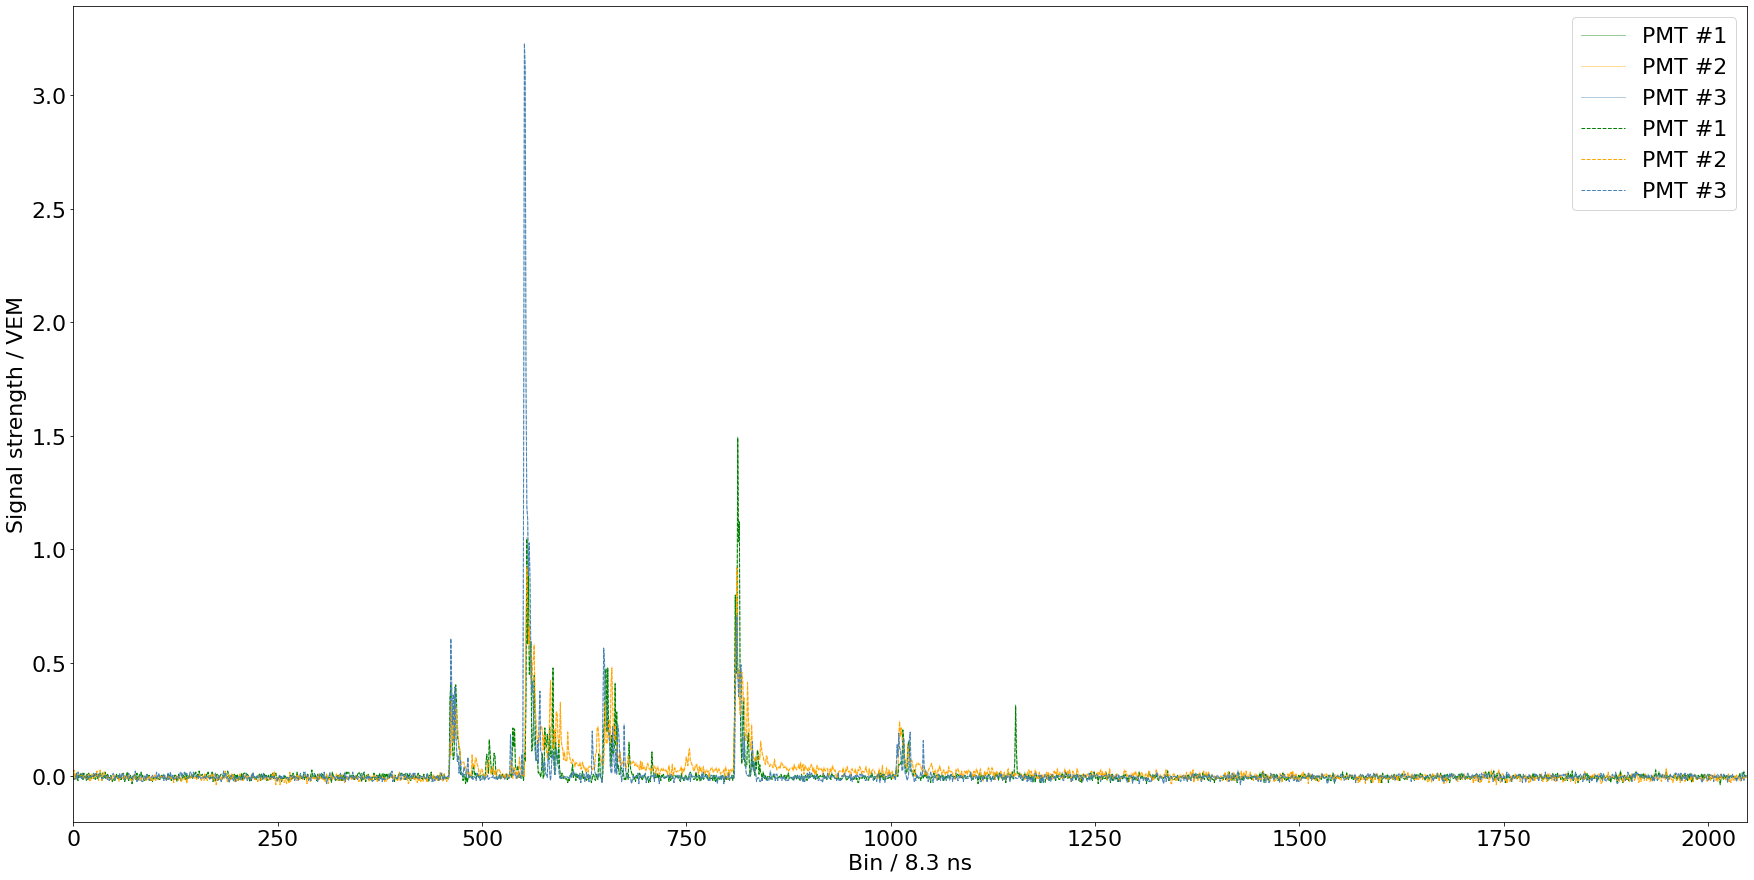

In [25]:
example_trace = 50
vem_metadata = VEM[example_trace * 3, :8]
q_peak = ADC[example_trace * 3 : example_trace * 3 + 3, 2]
DynAnRatio = ADC[example_trace * 3 : example_trace * 3 + 3, 4]
vem = VEM[example_trace * 3 : example_trace * 3 + 3, 8:]
adc = ADC[example_trace * 3 : example_trace * 3 + 3, 8:]
adc = [substract_baseline(pmt) for pmt in adc]
adc = [adc[i] * DynAnRatio[i] if DynAnRatio[i] else adc[i] for i in range(3)]

VEMTrace = Trace([[1, 1, 1], [0, 0, 0], 2048, 0, 0, None, False], vem, None)
ADCTrace = Trace([q_peak,    [0, 0, 0], 2048, 0, 0, None, False], adc, None)
VEMTrace.__plot__(ls = "solid", alpha = 0.4)
ADCTrace.__plot__(ls = "--")

In [6]:
import uproot

t_online, q_online = [], []

def calculate_start_end(station):

    starts = data['fCalibration.fStartSecond'].array()[station]
    deltas = data['fCalibration.fEndSecond'].array()[station]
    stops = starts + deltas

    return starts, stops, deltas

for string in ["mc_2022_03_16_00h00.root:SDMonCal", "mc_2022_03_17_00h00.root:SDMonCal", "mc_2022_03_18_00h00.root:SDMonCal"]:

    file = uproot.open(string)
    StationIDs = file['SDMonCalBranch']['fLsId'].array()
    Nuria = StationIDs == 56
    data = file['fCalibration']
    q_peak_nuria = data['fCalibration.fPeak[3]'].array()[Nuria]

    start_nuria, stop_nuria, dt_nuria = calculate_start_end(Nuria)

    for t, q in zip(0.5 * (start_nuria + stop_nuria), q_peak_nuria):
        t_online.append(t), q_online.append(q)

#     plt.figure()
#     plt.title("VEM Peak, " + stations[i])
#     plt.xlim(0, (seventeenth_march_end - seventeenth_march_start) / 3600)

#     
#     pmt_2 = station[:, 1]
#     pmt_3 = station[:, 2]

#     t = 0.5 * (starts_stations[i] + stops_stations[i])

#     plt.scatter((t - seventeenth_march_start) / 3600, pmt_1, c = "steelblue", label = f"PMT 1 - {np.mean(pmt_1):.2f}, RMS = {1e2 * np.std(pmt_1)/np.mean(pmt_1):.1f}%, PP = {1e2 * (max(pmt_1) - min(pmt_1))/np.mean(pmt_1):.1f}%")
#     plt.scatter((t - seventeenth_march_start) / 3600, pmt_2, c = "orange", label = f"PMT 2 - {np.mean(pmt_2):.2f}, RMS = {1e2 * np.std(pmt_2)/np.mean(pmt_2):.1f}%, PP = {1e2 * (max(pmt_2) - min(pmt_2))/np.mean(pmt_2):.1f}%")
#     plt.scatter((t - seventeenth_march_start) / 3600, pmt_3, c = "green", label = f"PMT 3 - {np.mean(pmt_3):.2f}, RMS = {1e2 * np.std(pmt_3)/np.mean(pmt_3):.1f}%, PP = {1e2 * (max(pmt_3) - min(pmt_3))/np.mean(pmt_3):.1f}%")
#     plt.xticks(ticks = range(0, 24, 2), labels = [f"{h}h" for h in range(0, 24, 2)])
#     plt.legend()


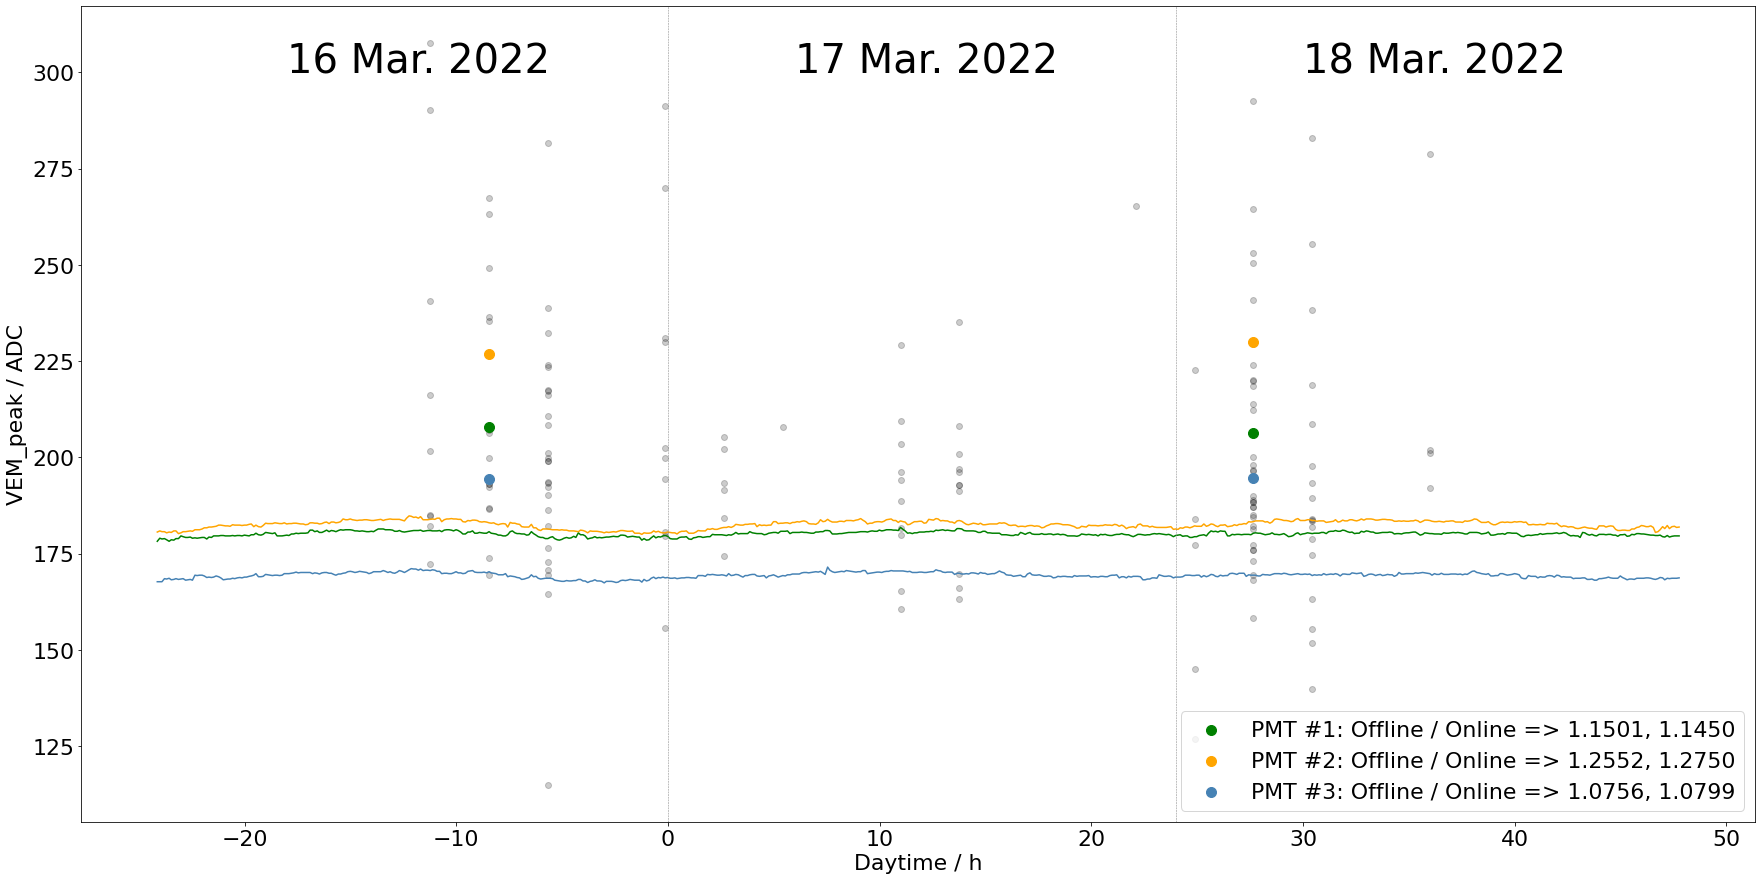

In [33]:
seventeenth_march_start = 1331510418
seventeenth_march_end = 1331596818

q_peak_all = np.split(ADC[:, 2], len(ADC[:, 2]) // 3)
timestamps_all = np.split(ADC[:, 5], len(ADC[:, 5]) // 3)
timestamps_all = np.array(timestamps_all)[:, 0]

station_id = 56                     # Nuria
# station_id = 1744                   # Le_Qui_Don
# station_id = 1742                   # Jaco
# station_id = 1737                   # Peru

Nuria_q = np.array(ADC)[ADC[:, 0] == station_id, 2]
Nuria_t = np.array(ADC)[ADC[:, 0] == station_id, 5]

label1 = f"PMT #1: Offline / Online => {Nuria_q[0] / np.array(q_online)[np.argmin(np.abs(Nuria_t[0] - t_online)), 0]:.4f}, {Nuria_q[3] / np.array(q_online)[np.argmin(np.abs(Nuria_t[3] - t_online)), 0]:.4f}"
label2 = f"PMT #2: Offline / Online => {Nuria_q[1] / np.array(q_online)[np.argmin(np.abs(Nuria_t[1] - t_online)), 0]:.4f}, {Nuria_q[4] / np.array(q_online)[np.argmin(np.abs(Nuria_t[4] - t_online)), 0]:.4f}"
label3 = f"PMT #3: Offline / Online => {Nuria_q[2] / np.array(q_online)[np.argmin(np.abs(Nuria_t[2] - t_online)), 0]:.4f}, {Nuria_q[5] / np.array(q_online)[np.argmin(np.abs(Nuria_t[5] - t_online)), 0]:.4f}"

plt.scatter((timestamps_all - seventeenth_march_start) / 3600, np.array(q_peak_all)[:,0], color = "k", alpha = 0.2)
plt.scatter((Nuria_t[::3] - seventeenth_march_start) / 3600, Nuria_q[::3], s = 100, c = "g", label = label1)
plt.scatter((Nuria_t[1::3] - seventeenth_march_start) / 3600, Nuria_q[1::3], s = 100, c = "orange", label = label2)
plt.scatter((Nuria_t[2::3] - seventeenth_march_start) / 3600, Nuria_q[2::3], s = 100, c = "steelblue", label = label3)
plt.plot((np.array(t_online) - seventeenth_march_start) / 3600, np.array(q_online)[:, 0], c = "green")
plt.plot((np.array(t_online) - seventeenth_march_start) / 3600, np.array(q_online)[:, 1], c = "orange")
plt.plot((np.array(t_online) - seventeenth_march_start) / 3600, np.array(q_online)[:, 2], c = "steelblue")


plt.axvline(0, c = "gray", ls = "--", lw = 0.5)
plt.axvline(24, c = "gray", ls = "--", lw = 0.5)
plt.annotate("16 Mar. 2022", [-18, 300], size = 40)
plt.annotate("17 Mar. 2022", [6, 300], size = 40)
plt.annotate("18 Mar. 2022", [30, 300], size = 40)

plt.ylabel("VEM_peak / ADC")
plt.xlabel("Daytime / h")
plt.legend(loc = "lower right")

In [11]:
# Nuria = StationIDs == 56
# Qui_Don = StationIDs == 1744
# Jaco = StationIDs == 1742
# Peru = StationIDs == 1737

participating_station = ADC[:,0]

print(f"\nNuria = {list(participating_station).count(56) // 3}")
print(f"Le_Qui_Don = {list(participating_station).count(1744) // 3}")
print(f"Jaco = {list(participating_station).count(1742) // 3}")
print(f"Peru = {list(participating_station).count(1737) // 3}")



Nuria = 2
Le_Qui_Don = 1
Jaco = 2
Peru = 3
